In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.preprocessing import LabelEncoder
import os

#Основной класс обработки датасета

*TODO: дописать требования к загружаемым датасетам*

In [3]:
class Dataset:

    def __init__(self, file_name='', client_class=None,
                 min_amount = 1000, min_year_credit = 2004,
                 pre_processing = False):

        # file_name - имя файла (str) или список файлов (list) с датасетами
        # client_class - класс клиента (int) или список классов клиентов (list)
        # min_amount - минимальная сумма кредита
        # min_year_credit - минимальный год выданного кредита
        # pre_processing - выполнять ли предобработку при загрузке датасетов (можно сделать позже)

        self.__min_amount = min_amount            # минимальная сумма кредита
        self.__min_year_credit = min_year_credit  # минимальный год выданного кредита
        self.__error_init = True                  # ошибка инициализации класса
        self.__datasets = []                      # список загруженных датасетов
        self.df = pd.DataFrame()                  # датафрейм
        self.__classes = client_class == True     # принимает значение True, если датасет был загружен с классами клиентов

        # загрузка датасета (датасетов)
        if file_name:
            self.load(file_name, client_class)

        # предобработка
        if file_name and pre_processing:
            self.pre_processing()

        

    def __len__(self):
        return self.df.shape[0]


    def __str__(self):
        return super().__str__()


    def __repr__(self):
        return super().__repr__()


    def __bool__(self):
        return not self.__error_init


    # Декоратор проверки инициализации класса
    def check_init(func):
        def wrapper(self, *args, **kwargs):
            if self.__error_init:
                raise Exception('Class initialization error')
            else:
                return func(self, *args, **kwargs)
        return wrapper


    @property
    def headers(self):
        """
        Список столбцов
        """

        # если была ошибка при инициализации класса, вызываем ошибку и выходим
        if self.__error_init:
            raise Exception('Class initialization error')

        return list(self.df)


    @check_init
    def save_as_xlsx(self, file_out):
        """
        Сохранение датасета в файл формата XLSX
        """
        self.df.to_excel(file_out)


    @check_init
    def save_as_csv(self, file_out):
        """
        Сохранение датасета в файл формата CSV
        """
        self.df.to_csv(file_out, index=False)


    def load(self, filename:str|list, client_class:int|list):
        """
        Загрузка датасета (датасетов)
        """

        # проверка списка файлов клиента
        if isinstance(filename, str):
            filename = [filename,]

        if not isinstance(filename, list):
            raise Exception('Filename type error')

        # проверка списка классов клиента
        if client_class:
            if isinstance(client_class, int):
                client_class = [client_class,]

            if not isinstance(client_class, list):
                raise Exception('Client class type error')

            if len(filename) != len(client_class):
                raise Exception('The length of the list of filenames and client classes must be equal')

        # TODO: добавить проверку наличия нужных для НС столбцов

        for idx, file in enumerate(filename):
            # проверка расширения файла и загрузка данных
            _, ext = os.path.splitext(file)

            print('loading:', file)

            match ext.lower():

                case '.xlsx':
                    excel_file = pd.ExcelFile(file)
                    df_new = excel_file.parse(excel_file.sheet_names[0])

                case '.csv':
                    df_new = pd.read_csv(file, low_memory=False)
                    # необходимо задать тип данных некоторых столбцов при чтении датасета в формате CSV
                    df_new[['issued']] = self.df[['issued']].astype('datetime64[ns]')

                case _:
                    self.__error_init = True
                    raise Exception('Filename extension error. Must be XLSX or CSV')

            # добавление класса клиентов к датасету
            if client_class:
                df_new['client_class'] = client_class[idx]

            # добавление датасета к уже существующему
            self.df = pd.concat([self.df, df_new])

        # TODO: для ускорения сделать список из датафреймов и в конце объединить их с этим списком

        self.__error_init = False


    @check_init
    def pre_processing(self):
        """
        Предобработка загруженного датасета
        """

        dfc = self.df

        # удаление строк по условиям
        dfc = dfc.drop(dfc[dfc.issued.dt.year < self.__min_year_credit].index)  # минимальная дата выданного кредита
        dfc = dfc.drop(dfc[dfc.amount < self.__min_amount].index)  # минимальная сумма кредита

        # удаление строк с пустым значением в определённых столбцах
        dfc = dfc.drop(dfc[dfc.type_credit==''].index)    # тип кредита
        dfc = dfc.drop(dfc[dfc.status_credit==''].index)  # статус кредита

        # удаление строк с недопустимой валютой (не RUR)
        dfc = dfc.drop(dfc[dfc.currency!='RUB'].index)

        self.df = dfc


    @check_init
    def analysis(self, del_scatter=False):
        """
        Анализ данных датасета:
        - анализ клиентов по качеству кредита
        - добавление столбцов с рейтингом качества кредита

        del_scatter - удаление разбросов (выбросов) в классе датасета
        """

        # Функции обработки столбца days_overdue

        # подсчёт всех записей (1234589ABC, остальные исключаем)
        def count_all_entries(word):
            sum_entries = sum([1 for letter in word if letter in ['1', '2', '3', '4', '5', '8', '9', 'A', 'B', 'C']])
            return 1 if sum_entries == 0 else sum_entries  # если столбец count_all_entries пустой, считаем что запись одна

        # подсчёт записей, указывающие на просрочку
        # исключаем B, т.к. считаем просрочку в 7 дней незначительной,
        # а так же A, т.к. это скорее всего 1я просрочка, хоть и длительная (на обсуждение)
        def count_overdue_entries(word):
            return sum([1 for letter in word if letter in ['2', '3', '4', '5', 'C']])

        # подсчёт записей, ухудшающих рейтинг
        # включен пункт 5 - "более 120 дней", можно добавить другие интервалы
        def count_downgrade_entries(word):
            return sum([1 for letter in word if letter in ['5', '8', '9']])

        # id_list = ds.df['id_nbki'].unique()  # получаем список id клиентов

        # копируем в новый dataframe столбцы, с которыми будем работать
        df = ds.df[['id_nbki', 'status_credit', 'days_overdue']].copy()

        # добавляем столбцы с дополнительными данными
        df['entries_sum'] = 0    # сумма записей о кредитах
        df['overdue_sum'] = 0    # сумма всех просрочек
        df['downgrade_sum'] = 0  # сумма всех ухудшающих рейтинг записей

        # принудительная установка типа столбца
        df[['days_overdue']] = df[['days_overdue']].astype('str')
        df[['entries_sum']] = df[['entries_sum']].astype('int')
        df[['overdue_sum']] = df[['overdue_sum']].astype('int')
        df[['downgrade_sum']] = df[['downgrade_sum']].astype('int')

        # -- Обработка данных

        # обрабатываем столбец days_overdue

        df['entries_sum'] = df['days_overdue'].apply(count_all_entries)  # сумма записей о кредитах
        df['overdue_sum'] = df['days_overdue'].apply(count_overdue_entries)  # сумма всех просрочек
        df['downgrade_sum'] = df['days_overdue'].apply(count_downgrade_entries)  # сумма всех ухудшающих рейтинг записей

        # обрабатываем столбец status_credit

        # если статус кредита "Просрочен", и нет значений в столбце "overdue_sum", прибавляем 1, иначе ничего не прибавляем, т.к. столбец уже обработан ранее
        df.loc[(df['status_credit'] == 'Просрочен') & (df['overdue_sum'] == 0), 'overdue_sum'] += 1

        # если есть соответствующий статус кредита, и нет значений в столбце "downgrade_sum", прибавляем 1
        df.loc[(df['status_credit'].isin(['Банкротство', 'ПринудительноеИсполнение', 'ПроблемыСВозвратом'])) & (df['downgrade_sum'] == 0), 'downgrade_sum'] += 1

        # подсчёт соотношений получившихся значений, выставляем исходя из этого рейтинг

        df_sum = df.groupby('id_nbki').agg({'entries_sum': 'sum', 'overdue_sum': 'sum', 'downgrade_sum': 'sum'}).reset_index()

        df_sum['overdue_prc'] = df_sum['overdue_sum'] / df_sum['entries_sum'] * 100  # процент просроченных платежей
        df_sum[['overdue_prc']] = df_sum[['overdue_prc']].astype('int')

        df_sum['downgrade_prc'] = df_sum['downgrade_sum'] / df_sum['entries_sum'] * 100  # процент снижающих рейтинг платежей
        df_sum[['downgrade_prc']] = df_sum[['downgrade_prc']].astype('int')

        df_sum['grade'] = (df_sum['overdue_sum'] / df_sum['entries_sum']) * 4  # рейтинг (0 - минимальное число просрочек, 3 - максимальное)
        df_sum[['grade']] = df_sum[['grade']].astype('int')

        df_sum = df_sum.assign(downgrade=df_sum['downgrade_sum'] > 0)  # есть ли снижающие рейтинг просрочки (банкротство, проблемы с возвратом, и т.д.)

        # TODO: сделать снижение рейтинга если были серьёзные просрочки
        # TODO: сделать максимальное значение grade=3

        # добавляем рейтинг в исходную таблицу
        self.df = pd.merge(ds.df, df_sum[['id_nbki', 'overdue_prc', 'downgrade_prc', 'grade', 'downgrade']], on='id_nbki')

        # удаляем выбросы в классах датасета (если они были загружены)
        if del_scatter and self.__classes:
            self.df = self.df.query('abs(client_class - grade) != 1')


    def processing(self):
        """
        Подготовка датасета к обработке нейросетью
        """

        # Применение LabelEncoder

        le_gender = LabelEncoder()         # пол
        le_education = LabelEncoder()      # образование
        le_position = LabelEncoder()       # должность
        le_type_credit = LabelEncoder()    # тип кредита
        le_status_credit = LabelEncoder()  # статус кредита

        self.df['le_gender'] = le_gender.fit_transform(self.df['gender'])
        self.df['le_education'] = le_education.fit_transform(self.df['education'])
        self.df['le_position'] = le_position.fit_transform(self.df['position'])
        self.df['le_type_credit'] = le_type_credit.fit_transform(self.df['type_credit'])
        self.df['le_status_credit'] = le_status_credit.fit_transform(self.df['status_credit'])

#Аналитика

Выводы после проведённых экспериментов (которые ниже):

Большой интерес представляет столбец **days_overdue**, т.к. в нём находятся данные по оплате кредита (в отличие от записей, где этот столбец не заполнен)

1й вариант записи в столбце days_overdue:

    0 - новый клиент оценка не возможна
    1 - оплата без просрочек
    А - просрочка от 1 до 29 дней
    В - просрочка от 1 до 7 дней
    С - просрочка от 8 до 29 дней
    2 - просрочка от 30 до 59 дней
    3 - просрочка от 60 до 89 дней
    4 - просрочка от 90 до 119 дней
    5 - просрочка более 120 дней
    7 - изменения/дополнения к договору
    Z - льготный период
    8 - погашение за счет обеспечения
    9 - безнадежный долг передано на взыскания

2й вариант записи в days_overdue и соответствие 1му варианту:

    1-5     - B
    6-29    - C
    30-59   - 2
    60-89   - 3
    90-119  - 4
    150-179 - 5
    180-209 - 5
    210-239 - 5
    240 и более - 5

Записи в столбце status_credit, снижающие рейтинг:

    Банкротство
    ПринудительноеИсполнение
    ПроблемыСВозвратом


Можно распарсить данные этого столбца, посчитать количество просрочек, количество вовремя погашенного кредита, а так же количество небольших просрочек (обозначенных **B**). Небольшие просрочки можно сложить с количеством вовремя погашенных кредитов.

Дополнительно, можно рассмотреть столбец **status_credit**. При налиие статуса **Просрочено**, так же это отметить.

Далее следует сложить наличия просрочек от столбца **status_credit** и посчитанных просрочек от столбца **days_overdue** и поделить на общее количество записей о кредите (считая все записи в столбце **status_credit**). В итоге получится доля просроченных кредитов. От этого значения можно выставлять рейтинг (так же от 0 до 3).

Так же следует отдельно выделить записи в столбце **status_credit**, которые выявляют проблемы с кредитом и должны снижать кредитный рейтинг:
*   Банкротство
*   ПринудительноеИсполнение
*   ПроблемыСВозвратом

Коментарий по поводу кредитов с суммой 0.1 (и обычно обозначенных статусом **ПроблемыСВозвратом**). Проблема в том, что изначально были мелкие остатки на счету после погашения кредита (10 копеек, и почему-то выделенных как отдельный кредит, возможно махинации кредитной организации), но человек об этом не знал, и за время набежали проценты и штрафы. В итоге долг вырастает до десятков тысяч, и человек принципиально платить отказывается. Как считать это в кредитной истории - непонятно. В алгоритме это решается отбрасыванием мелких изначальных сумм кредита.

Непонятно, как учитывать рейтинг, если имеется **Банкротство**. Можно ли выдавать кредит, в каком размере, и после какого времени после банкротства - надо изучать законодательство. Данных по этому случаю в общих датасетах может не хватать. В текущей модели это просто будет снижать рейтинг на 1.

В дальнейшем при обучении НС будет иметь смысл учитывать время кредитной истории, и придавать меньшее значение более старым записям, и большее - новым.

**Гипотеза:**
*   Сумма меньше 1000 р. смысловой нагрузки не имеет. Нужно установить минимальную сумму кредита, т.к. в датасете есть суммы примерно равные нулю. 
*   Минимальный год кредита в датасете - 2004. Для исключения выбросов то, что меньше, необходимо исключить
*   Необходимо убрать из выборки строки с нулевыми значениями. Столбцы, данные по которым нужно проверять - необходимо уточнять. На текущий момент - это **type_credit** (тип кредита) и **status_credit** (статус кредита). Возможно надо будет дополнить.
*   (?) нужно исключить все валюты, кроме рубля. Спорный момент, т.к. кредитная история в долларах - тоже история, хоть в датасете всего одна такая запись.

#Эксперименты

##Корреляция между столбцами

In [ ]:
ds.df.corr()

<ipython-input-85-a4735ac15e99>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds.df.corr()


,population,amount,psk,balance,current_indebtedness,expired,next_payment,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,maximum_amount_overdue_indebtedness,amount_principal_debt_repaid,availability_support
population,1.000000,0.008364,0.007282,0.015134,0.004031,0.004402,0.002896,0.001227,0.002736,-0.002571,0.001721,0.000068,0.001213,0.001675,0.000135,0.008116,0.009739,0.000434
amount,0.008364,1.000000,-0.015174,0.516383,0.127620,0.092864,0.059643,0.674555,0.101821,0.024413,0.199201,0.031245,0.057598,0.069333,0.249925,0.117128,0.431918,0.415503
psk,0.007282,-0.015174,1.000000,-0.005542,-0.000189,0.001763,-0.000501,-0.010579,0.001024,-0.002281,-0.005750,0.001770,-0.002706,-0.002984,-0.001211,-0.003754,-0.015341,-0.007418
balance,0.015134,0.516383,-0.005542,1.000000,0.023691,0.009649,-0.001739,0.221758,0.061716,0.043322,0.042854,0.001773,0.032086,0.075363,0.099912,0.034083,0.940990,0.248150
current_indebtedness,0.004031,0.127620,-0.000189,0.023691,1.000000,0.725623,0.516047,0.129922,0.016213,0.002522,0.160717,0.015106,0.010549,0.327677,-0.000070,-0.001526,-0.007157,0.014980
expired,0.004402,0.092864,0.001763,0.009649,0.725623,1.000000,0.695897,0.054299,0.004106,0.002761,0.213239,0.017853,0.013429,0.139733,0.000098,-0.000933,-0.004374,-0.001054
next_payment,0.002896,0.059643,-0.000501,-0.001739,0.516047,0.695897,1.000000,0.079371,0.005012,0.001716,0.002824,0.001314,-0.000352,0.026989,-0.000162,-0.000920,-0.004312,0.003631
term_indebtedness_body_loan,0.001227,0.674555,-0.010579,0.221758,0.129922,0.054299,0.079371,1.000000,0.152630,0.011359,0.005233,0.007164,-0.001125,0.044365,0.278703,0.011391,0.143190,0.357023
term_indebtedness_interest,0.002736,0.101821,0.001024,0.061716,0.016213,0.004106,0.005012,0.152630,1.000000,0.008947,0.006397,0.014787,0.030688,0.011248,0.045728,-0.003418,0.033809,0.069091
term_indebtedness_other,-0.002571,0.024413,-0.002281,0.043322,0.002522,0.002761,0.001716,0.011359,0.008947,1.000000,0.048889,0.054708,0.046530,0.000836,-0.000071,-0.000786,0.034813,0.002468


<ipython-input-83-f8a7944771bb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ds.df.corr()


<Axes: >

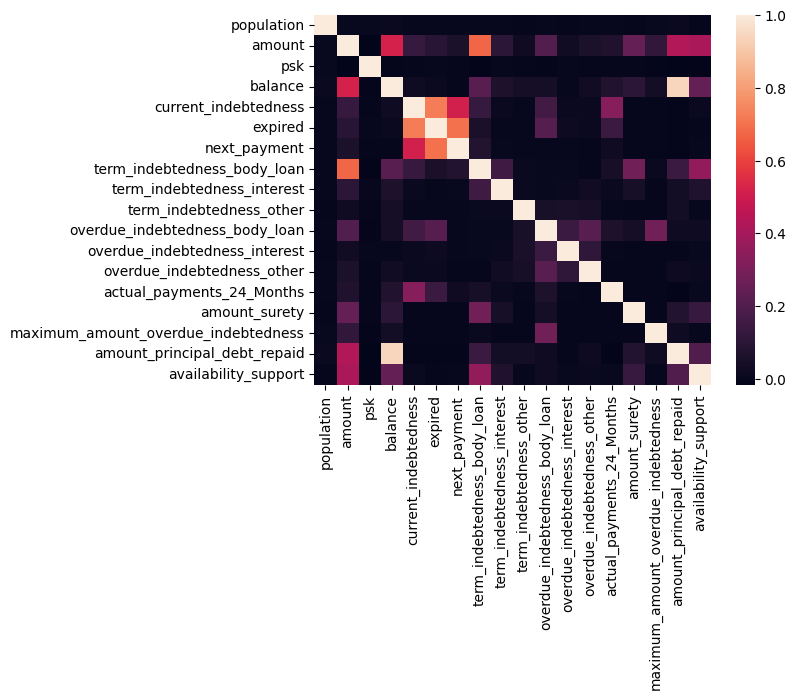

In [ ]:
import seaborn as sns
corr = ds.df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

<ipython-input-86-23c71a369720>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(ds.df.corr())


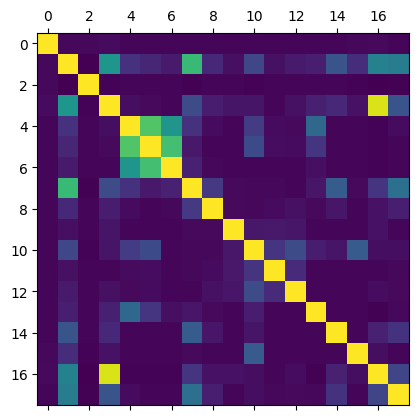

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(ds.df.corr())
plt.show()

In [ ]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-87-ce9744728a5b>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,population,amount,psk,balance,current_indebtedness,expired,next_payment,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,maximum_amount_overdue_indebtedness,amount_principal_debt_repaid,availability_support
population,1.00,0.01,0.01,0.02,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00
amount,0.01,1.00,-0.02,0.52,0.13,0.09,0.06,0.67,0.10,0.02,0.20,0.03,0.06,0.07,0.25,0.12,0.43,0.42
psk,0.01,-0.02,1.00,-0.01,-0.00,0.00,-0.00,-0.01,0.00,-0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.01
balance,0.02,0.52,-0.01,1.00,0.02,0.01,-0.00,0.22,0.06,0.04,0.04,0.00,0.03,0.08,0.10,0.03,0.94,0.25
current_indebtedness,0.00,0.13,-0.00,0.02,1.00,0.73,0.52,0.13,0.02,0.00,0.16,0.02,0.01,0.33,-0.00,-0.00,-0.01,0.01
expired,0.00,0.09,0.00,0.01,0.73,1.00,0.70,0.05,0.00,0.00,0.21,0.02,0.01,0.14,0.00,-0.00,-0.00,-0.00
next_payment,0.00,0.06,-0.00,-0.00,0.52,0.70,1.00,0.08,0.01,0.00,0.00,0.00,-0.00,0.03,-0.00,-0.00,-0.00,0.00
term_indebtedness_body_loan,0.00,0.67,-0.01,0.22,0.13,0.05,0.08,1.00,0.15,0.01,0.01,0.01,-0.00,0.04,0.28,0.01,0.14,0.36
term_indebtedness_interest,0.00,0.10,0.00,0.06,0.02,0.00,0.01,0.15,1.00,0.01,0.01,0.01,0.03,0.01,0.05,-0.00,0.03,0.07
term_indebtedness_other,-0.00,0.02,-0.00,0.04,0.00,0.00,0.00,0.01,0.01,1.00,0.05,0.05,0.05,0.00,-0.00,-0.00,0.03,0.00


###Выводы
Максимальная корреляция:

`0.94 - balance - amount_principal_debt_repaid`

`0.73 - expired - current_indebtedness`

`0.70 - expired - next_payment`

`0.67 - amount - term_indebtedness_body_loan`

`0.52 - balance - amount`

`0.52 - next_payment - current_indebtedness`

`0.43 - amount - amount_principal_debt_repaid`

`0.42 - amount - availability_support`

`0.36 - availability_support - term_indebtedness_body_loan`

`0.33 - current_indebtedness - actual_payments_24_Months`

`0.28 - amount_surety - term_indebtedness_body_loan`

`0.28 - overdue_indebtedness_body_loan - maximum_amount_overdue_indebtedness`

##Проверка и отладка класса обработки датасета

In [4]:
path = '/content/drive/MyDrive/UII/Fintex/'
file_input1_xls = 'dataset1_02.xlsx'
file_input2_xls = 'dataset2_02.xlsx'
file_output_xls = 'output.xlsx'
file_output_csv = 'output.csv'

file_in1 = f'{path}{file_input1_xls}'
file_in2 = f'{path}{file_input2_xls}'

In [ ]:
# загрузка датасетов (без классов)
ds = Dataset(file_name=[file_in1, file_in2], pre_processing=False)

loading: /content/drive/MyDrive/UII/Fintex/dataset1_02.xlsx
loading: /content/drive/MyDrive/UII/Fintex/dataset2_02.xlsx


In [ ]:
# загрузка датасетов с классами клиентов
ds = Dataset(file_name=[file_in1, file_in2], client_class=[0, 3], pre_processing=False)

loading: /content/drive/MyDrive/UII/Fintex/dataset1_02.xlsx
loading: /content/drive/MyDrive/UII/Fintex/dataset2_02.xlsx


In [ ]:
# Предобработка. Удаляет строки с нулевыми значениями, выбросы данных и т.д. (необходимо запускать перед анализом)
ds.pre_processing()

In [ ]:
# Анализ. Проверяет, выявляет и удаляет (при значении del_scatter = True) выбросы в классах клиентов
ds.analysis()  # по умолчанию del_scatter = False

In [5]:
ds = Dataset(file_name=[file_in1, file_in2], client_class=[0, 3])
ds.analysis(del_scatter=True)

loading: /content/drive/MyDrive/UII/Fintex/dataset1_02.xlsx
loading: /content/drive/MyDrive/UII/Fintex/dataset2_02.xlsx


In [6]:
# Подготовка датасета к обработке нейросетью
ds.processing()

In [ ]:
ds.df

,region_name,city_name,population,date of birth,gender,education,position,dt_nbki,id_nbki,issued,...,client_class,overdue_prc,downgrade_prc,grade,downgrade,le_gender,le_education,le_position,le_type_credit,le_status_credit
0,Новосибирская область,г. Барабинск,29122.0,1980-07-28,Женский,Высшее,работник бюджетной сферы,2023-03-05,27ab5815-bb2d-11ed-b80d-3cfdfed12971,2013-10-07,...,0,15,0,0,False,0,0,7,10,7
1,Новосибирская область,г. Барабинск,29122.0,1980-07-28,Женский,Высшее,работник бюджетной сферы,2023-03-05,27ab5815-bb2d-11ed-b80d-3cfdfed12971,2013-11-06,...,0,15,0,0,False,0,0,7,17,7
2,Новосибирская область,г. Барабинск,29122.0,1980-07-28,Женский,Высшее,работник бюджетной сферы,2023-03-05,27ab5815-bb2d-11ed-b80d-3cfdfed12971,2016-04-05,...,0,15,0,0,False,0,0,7,11,12
3,Новосибирская область,г. Барабинск,29122.0,1980-07-28,Женский,Высшее,работник бюджетной сферы,2023-03-05,27ab5815-bb2d-11ed-b80d-3cfdfed12971,2016-04-16,...,0,15,0,0,False,0,0,7,11,12
4,Новосибирская область,г. Барабинск,29122.0,1980-07-28,Женский,Высшее,работник бюджетной сферы,2023-03-05,27ab5815-bb2d-11ed-b80d-3cfdfed12971,2016-05-13,...,0,15,0,0,False,0,0,7,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234663,Ставропольский край,г. Невинномысск,116884.0,1946-09-15,Женский,СреднеТехническое,пенсионер,2020-10-30,392179ad-1ab6-11eb-80c7-f4034344a6bd,2014-09-02,...,3,0,0,0,False,0,4,5,17,12
234664,Ставропольский край,г. Невинномысск,116884.0,1946-09-15,Женский,СреднеТехническое,пенсионер,2020-10-30,392179ad-1ab6-11eb-80c7-f4034344a6bd,2012-10-07,...,3,0,0,0,False,0,4,5,17,12
234665,Ставропольский край,г. Невинномысск,116884.0,1946-09-15,Женский,СреднеТехническое,пенсионер,2020-10-30,392179ad-1ab6-11eb-80c7-f4034344a6bd,2012-08-01,...,3,0,0,0,False,0,4,5,17,12
234666,Ставропольский край,г. Невинномысск,116884.0,1946-09-15,Женский,СреднеТехническое,пенсионер,2020-10-30,392179ad-1ab6-11eb-80c7-f4034344a6bd,2011-01-24,...,3,0,0,0,False,0,4,5,17,12


In [ ]:
ds.headers

['region_name',
 'city_name',
 'population',
 'date of birth',
 'gender',
 'education',
 'position',
 'dt_nbki',
 'id_nbki',
 'issued',
 'amount',
 'currency',
 'type_credit',
 'status_credit',
 'period',
 'period_interest',
 'psk',
 'balance',
 'current_indebtedness',
 'expired',
 'days_overdue',
 'next_payment',
 'last_payment',
 'updated',
 'term_indebtedness_body_loan',
 'term_indebtedness_interest',
 'term_indebtedness_other',
 'overdue_indebtedness_body_loan',
 'overdue_indebtedness_interest',
 'overdue_indebtedness_other',
 'actual_payments_24_Months',
 'volume_commitment',
 'amount_surety',
 'surety_period',
 'source_information',
 'maximum_amount_overdue_indebtedness',
 'date_credit_state',
 'beginning_days_delinquency_counting',
 'type_debt',
 'amount_principal_debt_repaid',
 'availability_support',
 'client_class',
 'overdue_prc',
 'downgrade_prc',
 'grade',
 'downgrade',
 'le_gender',
 'le_education',
 'le_position',
 'le_type_credit',
 'le_status_credit']

Следующие шаги:
* сделать преобразование записи просроченных кредитов вида 1-6, 7-29 в A, B
* определить, какие столбцы нужны для дальнейшей работы в Autokeras

##Autokeras

In [7]:
import pandas as pd
from IPython.display import display
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
# копируем только те столбцы, которые принимают участие в обучении НС
df = ds.df[['id_nbki', 'population', 'le_gender', 'le_education', 'le_position', 'date of birth',
            'amount', 'le_type_credit', 'le_status_credit', 'psk', 'balance', 'current_indebtedness',
            'expired', 'days_overdue', 'next_payment', 'term_indebtedness_body_loan',
            'term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
            'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months',
            'amount_principal_debt_repaid']].copy()
# df = df.drop('Date', axis=1)

In [17]:
# нормировка столбцов Weekly_Sales, Temperature, Fuel_Price, CPI и Unemployment
scaler = MinMaxScaler()
df[['population', 'amount', 'psk', 'balance', 'current_indebtedness',
    'expired', 'next_payment', 'term_indebtedness_body_loan',
    'term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
    'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months',
    'amount_principal_debt_repaid']] = \
    scaler.fit_transform(df[['population', 'amount', 'psk', 'balance', 'current_indebtedness',
    'expired', 'next_payment', 'term_indebtedness_body_loan',
    'term_indebtedness_interest', 'term_indebtedness_other', 'overdue_indebtedness_body_loan',
    'overdue_indebtedness_interest', 'overdue_indebtedness_other', 'actual_payments_24_Months',
    'amount_principal_debt_repaid']])

In [ ]:
# TODO: добавить обработку (через LabelEncoder) столбец type_debt

In [18]:
# подсчет строк с отсутствующими значениями
df.isna().sum()

id_nbki                                0
population                            22
le_gender                              0
le_education                           0
le_position                            0
date of birth                          0
amount                               419
le_type_credit                         0
le_status_credit                       0
psk                                  419
balance                              419
current_indebtedness                 419
expired                              419
days_overdue                      173179
next_payment                         419
term_indebtedness_body_loan          419
term_indebtedness_interest           419
term_indebtedness_other              419
overdue_indebtedness_body_loan       419
overdue_indebtedness_interest        419
overdue_indebtedness_other           419
actual_payments_24_Months            419
amount_principal_debt_repaid         419
dtype: int64

In [24]:
# выделение признаков и целевой переменной
x = df.copy()
y = ds.df['client_class'].replace(3, 1)

In [25]:
# разделение датасета на обучающую и проверочную выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# вывод размеров обучающей и проверочной выборок
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер проверочной выборки: {X_test.shape[0]}')

Размер обучающей выборки: 187734
Размер проверочной выборки: 46934


In [26]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 115.8 MB/s eta 0:00:00


In [27]:
import autokeras as ak

In [28]:
# инициализация класса автоматического машинного обучения
reg2 = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials=50,
    tuner="hyperband",
    loss='mean_squared_error',
    metrics=['mean_absolute_error'],
    project_name='weekly_sales_forecast2'
)

# поиск лучшей модели
reg2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 50 Complete [00h 02m 45s]
val_loss: 0.1636195033788681

Best val_loss So Far: 0.10400569438934326
Total elapsed time: 02h 24m 43s
Epoch 1/20
5867/5867 [==============================] - 15s 2ms/step - loss: 0.1086 - mean_absolute_error: 0.2220 - val_loss: 0.1073 - val_mean_absolute_error: 0.2124
Epoch 2/20
5867/5867 [==============================] - 14s 2ms/step - loss: 0.0928 - mean_absolute_error: 0.1900 - val_loss: 0.1016 - val_mean_absolute_error: 0.2150
Epoch 3/20
5867/5867 [==============================] - 13s 2ms/step - loss: 0.0880 - mean_absolute_error: 0.1842 - val_loss: 0.1022 - val_mean_absolute_error: 0.2015
Epoch 4/20
5867/5867 [==============================] - 13s 2ms/step - loss: 0.0909 - mean_absolute_error: 0.1906 - val_loss: 0.0960 - val_mean_absolute_error: 0.2001
Epoch 5/20
5867/5867 [==============================] - 13s 2ms/step - loss: 0.0854 - mean_absolute_error: 0.1788 - val_loss: 0.0948 - val_mean_absolute_error: 0.2049
Epoch 6/20
5867/5867 [=======

здесь колаб остановился и не вывел лучшую модель

In [ ]:
best_model2 = reg2.export_model()
# Получите архитектуру модели в виде JSON строки
model_json2 = best_model2.to_json()

print("Model architecture:")
print(model_json2)

In [ ]:
best_model2.summary()

необходимы последующие эксперименты, в т.ч. с другими методами Autokeras, а так же проверить ещё теории по обработке датасета